✅ Model loaded from models/knn_model.pkl


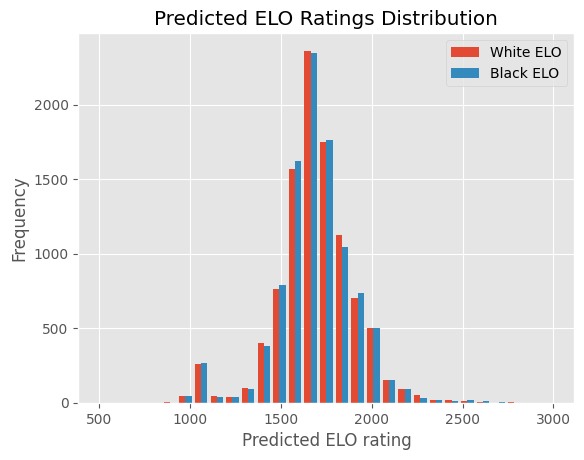


📊 Results:
{
    "Description": "ELO prediction test",
    "Model": "models/knn_model.pkl",
    "# Games for testing": 10000,
    "Test Predict time": 855.6944766044617,
    "Test R2 score": 0.8684435978020172,
    "Test MSE": 8851.320768065892
}


In [5]:
import chess
import chess.pgn
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import time
import joblib
import json
import matplotlib.pyplot as plt

# Use a valid Matplotlib style
plt.style.use('ggplot')

TEST_FILE = 'data/10000_games.pgn'

def games_to_opening_vecs(games):
    return np.array(list(map(lambda game: chess_utils.game_to_vec(game, 35), games)))

def gaussian_kernel(distances):
    weights = np.exp(-75 * (distances ** 2))
    return weights / np.sum(weights)


def load_pgn_data(file_path, test_count):
    """Load PGN data and extract ELO ratings."""
    pgn = open(file_path)
    X_test = []
    y_test = []
    
    for _ in range(test_count):
        game = chess.pgn.read_game(pgn)
        if game is not None:
            X_test.append(game)
            y_test.append([int(game.headers['WhiteElo']), int(game.headers['BlackElo'])])

    return X_test, np.array(y_test)


def test_model(model_path, test_count, output_filename, description=None):
    """Test the model on PGN data and save the results."""
    
    # Load the model
    model = joblib.load(model_path)
    print(f"✅ Model loaded from {model_path}")
    
    # Load test data
    X_test, y_test = load_pgn_data(TEST_FILE, test_count)
    
    # Convert PGN games to feature vectors
    import chess_utils  # Ensure you have the `game_to_vec` function
    # Convert PGN games to feature vectors with the missing argument
    MOVES_LIMIT = 35  # Define the move limit
    X_test_vec = np.array([chess_utils.game_to_vec(game, moves_limit=MOVES_LIMIT).reshape(-1) for game in X_test])


    # Model prediction
    pred_start = time.time()
    y_pred = model.predict(X_test_vec)
    pred_end = time.time()
    pred_time = pred_end - pred_start

    # Evaluation metrics
    test_R2 = r2_score(y_test, y_pred)
    test_MSE = mean_squared_error(y_test, y_pred)

    # Plot histogram
    bins = np.linspace(500, 3000, 30)
    plt.hist([y_pred[:, 0], y_pred[:, 1]], bins, label=['White ELO', 'Black ELO'])
    plt.title("Predicted ELO Ratings Distribution")
    plt.xlabel("Predicted ELO rating")
    plt.ylabel("Frequency")
    plt.legend(loc='upper right')
    plt.show()

    # Save results
    results = {
        'Description': description,
        'Model': model_path,
        '# Games for testing': test_count,
        'Test Predict time': pred_time,
        'Test R2 score': test_R2,
        'Test MSE': test_MSE
    }
    
    print("\n📊 Results:")
    print(json.dumps(results, indent=4))

    with open(f'test_reports/{output_filename}.json', 'w') as file:
        json.dump(results, file)


# Example usage:
test_model('models/knn_model.pkl', 10000, 'test_results', description="ELO prediction test")
